In [ ]:
import torch
import torchvision.models as models
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
X = torch.randn(100,3,150,150, requires_grad=False)
vgg.float()
y = vgg(X)

In [ ]:
y.shape

torch.Size([100, 1000])

In [ ]:
pred = torch.pca_lowrank(y)

In [ ]:
pred[2].shape

torch.Size([1000, 6])

In [ ]:
C1.requires_grad_=False
C2.requires_grad_=False

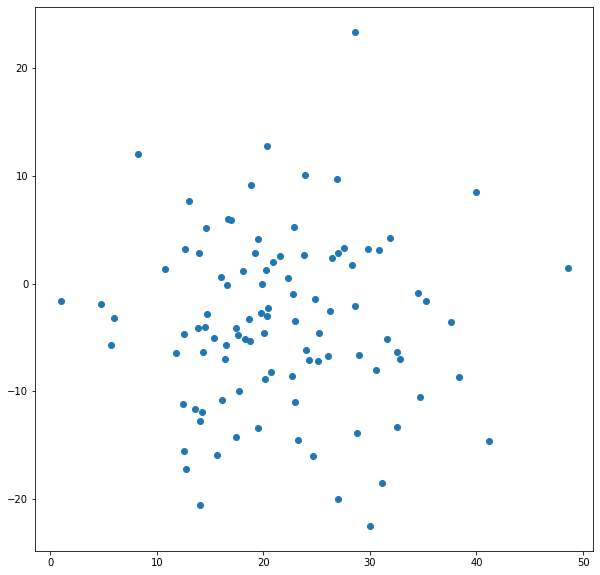

In [ ]:
#pytorch_pca
C = torch.matmul(y, pred[2][:, :2])
C1 = C[:,0]
C2 = C[:,1]
C1 = C1.detach().numpy()
C2 = C2.detach().numpy()
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(C1, C2)

In [ ]:
#sklearn
y2 = y.detach().numpy()
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
C_ = pca.fit_transform(y2)

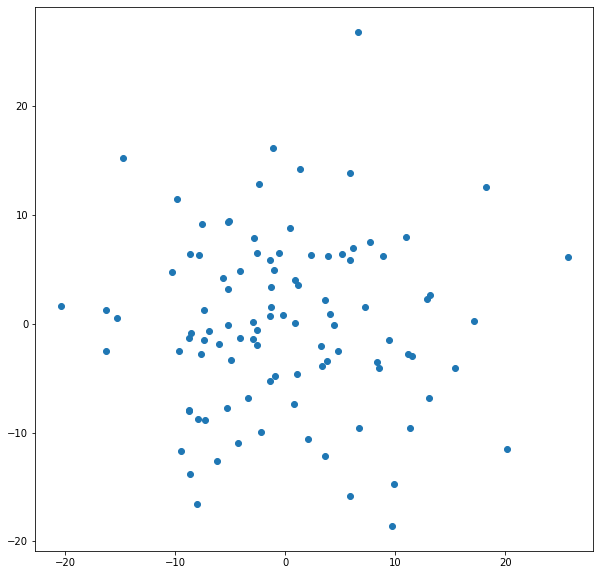

In [ ]:
C1_ = C_[:,0]
C2_ = C_[:,1]
plt.figure(figsize=(10,10))
plt.scatter(C1_, C2_)

In [8]:
from torch import nn
import torchvision.models as models
net = nn.Sequential(
    models.vgg16(pretrained=True),
    nn.Conv2d(1000, 64, 1),
    nn.ReLU(),
    nn.MaxPool2d(2)
    )

In [12]:
list(net.parameters())[0].device()

TypeError: ignored

In [ ]:
import torch
X = torch.randn(100,3,150,150, requires_grad=False)
net(X)

RuntimeError: ignored

In [ ]:
#每個epoch都用model的當下狀況去loop 所有的test data得到當下的acc
def evaluate_accuracy(data_iter, net, device=None):
  if device is None and isinstance(net, torch.Module):
    device = list(net.parameters())[0].device
  acc_sum, n = 0.0, 0
  with torch.no_grad():
    for X, y in data_iter():
      if isinstance(net, nn.Module):
        net.eval() #才可關閉dropout
        acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item() #是pytorch就要to(device)
        net.train() #訓練到下一個epoch才會正常
      else:
        if 'is_training' in net.__code__.co_varnames:
          acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
        else:
          acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
      n += y.shape[0] #acc要除以整個data_size
    return acc_sum/n
  

In [ ]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n